<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/HiGNN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Get all functions from
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import Random
from collections import defaultdict

import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.data import DataLoader

from rdkit import Chem
from rdkit.Chem.BRICS import FindBRICSBonds
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger

from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, Parameter, Bilinear

from torch_scatter import scatter
from torch_geometric.nn import global_add_pool, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, reset
from torch_geometric.nn.pool.pool import pool_batch
from torch_geometric.nn.pool.consecutive import consecutive_cluster
import wandb


import os
import torch.nn.init as init
from torch_geometric.utils import softmax
from torch_geometric.nn import global_mean_pool

from ipdb import set_trace as st

# Section - 1: All the Helper Functions

In [5]:
# This cell consists of all the helper functions and helper classes that are required to create a dataset.
def onehot_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return [x == s for s in allowable_set]


def onehot_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]


def atom_attr(mol, explicit_H=False, use_chirality=True, pharmaco=True, scaffold=True):
    if pharmaco:
        mol = tag_pharmacophore(mol)
    if scaffold:
        mol = tag_scaffold(mol)

    feat = []
    for i, atom in enumerate(mol.GetAtoms()):
        results = onehot_encoding_unk(
            atom.GetSymbol(),
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At', 'other'
             ]) + onehot_encoding_unk(atom.GetDegree(),
                                      [0, 1, 2, 3, 4, 5, 'other']) + \
                  [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                  onehot_encoding_unk(atom.GetHybridization(), [
                      Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                      Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                      Chem.rdchem.HybridizationType.SP3D2, 'other'
                  ]) + [atom.GetIsAromatic()]
        if not explicit_H:
            results = results + onehot_encoding_unk(atom.GetTotalNumHs(),
                                                    [0, 1, 2, 3, 4])
        if use_chirality:
            try:
                results = results + onehot_encoding_unk(
                    atom.GetProp('_CIPCode'),
                    ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
            # print(one_of_k_encoding_unk(atom.GetProp('_CIPCode'), ['R', 'S']) + [atom.HasProp('_ChiralityPossible')])
            except:
                results = results + [0, 0] + [atom.HasProp('_ChiralityPossible')]
        if pharmaco:
            results = results + [int(atom.GetProp('Hbond_donor'))] + [int(atom.GetProp('Hbond_acceptor'))] + \
                      [int(atom.GetProp('Basic'))] + [int(atom.GetProp('Acid'))] + \
                      [int(atom.GetProp('Halogen'))]
        if scaffold:
            results = results + [int(atom.GetProp('Scaffold'))]
        feat.append(results)

    return np.array(feat)


def bond_attr(mol, use_chirality=True):
    feat = []
    index = []
    n = mol.GetNumAtoms()
    for i in range(n):
        for j in range(n):
            if i != j:
                bond = mol.GetBondBetweenAtoms(i, j)
                if bond is not None:
                    bt = bond.GetBondType()
                    bond_feats = [
                        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                        bond.GetIsConjugated(),
                        bond.IsInRing()
                    ]
                    if use_chirality:
                        bond_feats = bond_feats + onehot_encoding_unk(
                            str(bond.GetStereo()),
                            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
                    feat.append(bond_feats)
                    index.append([i, j])

    return np.array(index), np.array(feat)


def bond_break(mol):
    results = np.array(sorted(list(FindBRICSBonds(mol))), dtype=np.long)

    if results.size == 0:
        cluster_idx = []
        Chem.rdmolops.GetMolFrags(mol, asMols=True, frags=cluster_idx)
        fra_edge_index, fra_edge_attr = bond_attr(mol)

    else:
        bond_to_break = results[:, 0, :]
        bond_to_break = bond_to_break.tolist()
        with Chem.RWMol(mol) as rwmol:
            for i in bond_to_break:
                rwmol.RemoveBond(*i)
        rwmol = rwmol.GetMol()
        cluster_idx = []
        Chem.rdmolops.GetMolFrags(rwmol, asMols=True, sanitizeFrags=False, frags=cluster_idx)
        fra_edge_index, fra_edge_attr = bond_attr(rwmol)
        cluster_idx = torch.LongTensor(cluster_idx)

    return fra_edge_index, fra_edge_attr, cluster_idx


# ---------------------------------------------
# Scaffold and pharmacophore information utils
# ---------------------------------------------
# tag pharmoco features to each atom
fun_smarts = {
        'Hbond_donor': '[$([N;!H0;v3,v4&+1]),$([O,S;H1;+0]),n&H1&+0]',
        'Hbond_acceptor': '[$([O,S;H1;v2;!$(*-*=[O,N,P,S])]),$([O,S;H0;v2]),$([O,S;-]),$([N;v3;!$(N-*=[O,N,P,S])]),n&X2&H0&+0,$([o,s;+0;!$([o,s]:n);!$([o,s]:c:n)])]',
        'Basic': '[#7;+,$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);!$([C,a](=O))]),$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))]),$([n;X2;+0;-0])]',
        'Acid': '[C,S](=[O,S,P])-[O;H1,-1]',
        'Halogen': '[F,Cl,Br,I]'
        }
FunQuery = dict([(pharmaco, Chem.MolFromSmarts(s)) for (pharmaco, s) in fun_smarts.items()])


def tag_pharmacophore(mol):
    for fungrp, qmol in FunQuery.items():
        matches = mol.GetSubstructMatches(qmol)
        match_idxes = []
        for mat in matches:
            match_idxes.extend(mat)
        for i, atom in enumerate(mol.GetAtoms()):
            tag = '1' if i in match_idxes else '0'
            atom.SetProp(fungrp, tag)
    return mol


# tag scaffold information to each atom
def tag_scaffold(mol):
    core = MurckoScaffold.GetScaffoldForMol(mol)
    match_idxes = mol.GetSubstructMatch(core)
    for i, atom in enumerate(mol.GetAtoms()):
        tag = '1' if i in match_idxes else '0'
        atom.SetProp('Scaffold', tag)
    return mol

In [16]:
class MolData(Data):
    def __init__(self, fra_edge_index=None, fra_edge_attr=None, cluster_index=None, **kwargs):
        super(MolData, self).__init__(**kwargs)
        self.cluster_index = cluster_index
        self.fra_edge_index = fra_edge_index
        self.fra_edge_attr = fra_edge_attr

    def __inc__(self, key, value, *args, **kwargs):
        if key == 'cluster_index':
            return int(self.cluster_index.max()) + 1
        else:
            return super().__inc__(key, value, *args, **kwargs)


class MolDataset(InMemoryDataset):

    def __init__(self, root, fpath, dataset, task_type, tasks, logger=None, smiles_col = 'smiles',
                 transform=None, pre_transform=None, pre_filter=None):

        self.tasks = tasks
        self.dataset = dataset
        self.task_type = task_type
        self.logger = logger
        self.fpath = fpath
        self.smiles_col = smiles_col

        super(MolDataset, self).__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['{}.csv'.format(self.dataset)]

    @property
    def processed_file_names(self):
        return ['{}.pt'.format(self.dataset)]

    def download(self):
        pass

    def process(self):

        df = pd.read_csv(self.fpath)

        df = df[:100]
        smilesList = df[self.smiles_col].values

        print(f'number of all smiles: {len(smilesList)}')
        remained_smiles = []
        canonical_smiles_list = []
        for smiles in smilesList:
            try:
                canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
                remained_smiles.append(smiles)
            except:
                self.logger.info(f'not successfully processed smiles: {smiles}')
                pass

        print(f'number of successfully processed smiles: {len(remained_smiles)}')
        df = df[df[self.smiles_col].isin(remained_smiles)].reset_index()

        target = df[self.tasks].values
        smilesList = df[self.smiles_col].values
        data_list = []

        for i, smi in enumerate(tqdm(smilesList)):

            mol = Chem.MolFromSmiles(smi)
            data = self.mol2graph(mol)

            if data is not None:
                label = target[i]
                label[np.isnan(label)] = 666
                data.y = torch.LongTensor([label])
                if self.task_type == 'regression':
                    data.y = torch.FloatTensor([label])
                data_list.append(data)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def mol2graph(self, mol):
        smiles = Chem.MolToSmiles(mol)
        if mol is None: return None
        node_attr = atom_attr(mol, scaffold = False)
        edge_index, edge_attr = bond_attr(mol)
        fra_edge_index, fra_edge_attr, cluster_index = bond_break(mol)
        data = MolData(
            x=torch.FloatTensor(node_attr),
            edge_index=torch.LongTensor(edge_index).t(),
            edge_attr=torch.FloatTensor(edge_attr),
            fra_edge_index=torch.LongTensor(fra_edge_index).t(),
            fra_edge_attr=torch.FloatTensor(fra_edge_attr),
            cluster_index=torch.LongTensor(cluster_index),
            y=None,
            smiles=smiles,
        )
        return data

In [17]:
def load_dataset_random(root, fpath, dataset, task_type, tasks=None, smiles_col = 'smiles', seed = 201):
    # save_path = path + 'processed/train_valid_test_{}_seed_{}.ckpt'.format(dataset, seed)
    # if os.path.isfile(save_path):
    #     trn, val, test = torch.load(save_path)
    #     return trn, val, test

    pyg_dataset = MolDataset(root=root, fpath = fpath, dataset=dataset, task_type=task_type, tasks=tasks, smiles_col = smiles_col)
    del pyg_dataset.data.smiles

    # Seed randomness
    random = Random(seed)
    indices = list(range(len(pyg_dataset)))
    random.seed(seed)
    random.shuffle(indices)

    train_size = int(0.8 * len(pyg_dataset))
    val_size = int(0.1 * len(pyg_dataset))
    test_size = len(pyg_dataset) - train_size - val_size

    trn_id, val_id, test_id = indices[:train_size], \
                              indices[train_size:(train_size + val_size)], \
                              indices[(train_size + val_size):]

    trn, val, test = pyg_dataset[torch.LongTensor(trn_id)], \
                     pyg_dataset[torch.LongTensor(val_id)], \
                     pyg_dataset[torch.LongTensor(test_id)]

    print(f'Total smiles = {len(pyg_dataset):,} | '
                f'train smiles = {train_size:,} | '
                f'val smiles = {val_size:,} | '
                f'test smiles = {test_size:,}')

    assert task_type == 'classification' or 'regression'
    if task_type == 'classification':
        weights = []
        for i in range(len(tasks)):
            validId = np.where((pyg_dataset.data.y[:, i] == 0) | (pyg_dataset.data.y[:, i] == 1))[0]
            pos_len = (pyg_dataset.data.y[:, i][validId].sum()).item()
            neg_len = len(pyg_dataset.data.y[:, i][validId]) - pos_len
            weights.append([(neg_len + pos_len) / neg_len, (neg_len + pos_len) / pos_len])
        trn.weights = weights

    else:
        trn.weights = None

    # torch.save([trn, val, test], save_path)
    return trn, val, test

def get_loaders(root, fpath, dataset, task_type = 'regression', tasks=None, smiles_col = 'smiles', seed = 201, bs = 32):

    '''
    This function prepares data loaders by using other helper functions.

    Args:
      root {Str}: Path to store saved data. Not csv file path
      path {Str}: Path to the CSV file
      smiles_col {Str}: smiles column name in the csv file
      label_col {Str or List}: Label column name in the csv file
      task_type {Str}: is it regression or classification
      bs {Int}: Batch size, use 32 if GPU available, else use 4.
    '''

    train, val, test = load_dataset_random(root, fpath, dataset, task_type, tasks = tasks, smiles_col = smiles_col, seed = seed)

    # train, val, test = load_dataset_random()
    train_dataloader = DataLoader(train, batch_size = bs, shuffle=True)
    valid_dataloader = DataLoader(val, bs)
    test_dataloader = DataLoader(test, bs)

    return train_dataloader, valid_dataloader, test_dataloader

In [8]:
wandb.init(project = "HiGNN Implementation - 3")

wandb: Currently logged in as: bindelapranay1997 (comp_chem). Use `wandb login --relogin` to force relogin


In [18]:
# This Cell consists of helper functions and base classes of HiGNN and the Message Passing Architecture.

class FeatureAttention(nn.Module):
    '''
    c = (W5 (W4fG sum ) + W5 (W4fG max ))
    '''
    def __init__(self, channels, reduction):
        super().__init__()
        self.mlp = Sequential(
            Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            Linear(channels // reduction, channels, bias=False),
        )

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.mlp)

    def forward(self, x, batch, size=None):
        max_result = scatter(x, batch, dim=0, dim_size=size, reduce='max')
        sum_result = scatter(x, batch, dim=0, dim_size=size, reduce='sum')
        max_out = self.mlp(max_result)
        sum_out = self.mlp(sum_result)
        y = torch.sigmoid(max_out + sum_out)
        y = y[batch]
        return x * y

# ---------------------------------------
# Neural tensor networks conv
# ---------------------------------------
class NTNConv(MessagePassing):

    '''
    Base Message Passing Class for HiGNN. Core of the architecture.
    alpha(i j) = tanh(hi W[ ]h + W[h , h ] + b)
    d = d/a
    mi = ReLU(reshape(alpha(i, j), hj , d))
    β = W3T.[hi,mi,hi − mi].
    hi = β.hi + (1 - β).mi
    '''

    def __init__(self, in_channels, out_channels, slices, dropout, edge_dim=None, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(NTNConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.slices = slices
        self.dropout = dropout
        self.edge_dim = edge_dim

        self.weight_node = Parameter(torch.Tensor(in_channels,
                                                  out_channels))
        if edge_dim is not None:
            self.weight_edge = Parameter(torch.Tensor(edge_dim,
                                                      out_channels))
        else:
            self.weight_edge = self.register_parameter('weight_edge', None)

        self.bilinear = Bilinear(out_channels, out_channels, slices, bias=False)

        if self.edge_dim is not None:
            self.linear = Linear(3 * out_channels, slices)
        else:
            self.linear = Linear(2 * out_channels, slices)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight_node)
        glorot(self.weight_edge)
        self.bilinear.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=None):

        x = torch.matmul(x, self.weight_node)

        if self.weight_edge is not None:
            assert edge_attr is not None
            edge_attr = torch.matmul(edge_attr, self.weight_edge)

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        alpha = self._alpha
        self._alpha = None

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_attr):
        score = self.bilinear(x_i, x_j)
        if edge_attr is not None:
            vec = torch.cat((x_i, edge_attr, x_j), 1)
            block_score = self.linear(vec)  # bias already included
        else:
            vec = torch.cat((x_i, x_j), 1)
            block_score = self.linear(vec)
        scores = score + block_score
        alpha = torch.tanh(scores)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        dim_split = self.out_channels // self.slices
        out = torch.max(x_j, edge_attr).view(-1, self.slices, dim_split)

        out = out * alpha.view(-1, self.slices, 1)
        out = out.view(-1, self.out_channels)
        return out

    def __repr__(self):
        return '{}({}, {}, slices={})'.format(self.__class__.__name__,
                                              self.in_channels,
                                              self.out_channels, self.slices)

class HiGNN(torch.nn.Module):
    """Hierarchical informative graph neural network for molecular representation.

    There are 2 parts to HiGNN, one is at molecule level and other is at fragment level.
    We do message passing at both levels (Atom Level and Fragment Level)

    Once after Message Passing,
      1. mean pool atom attributes
      2. Calculate Cross Attention scores of each of those fragment attributes to molecule attributes
      3. Weighted sum of fragment attributes using cross attention scores
      4. Concatenate molecule attributes obtained from atom level features and fragment level features and get prediction.

    After Message Passing

    Readout:
      hg = sigme(hi)

    Cross Attention -
    hg - Graph Readout
    st - Fragment Representation of Message Passing.

    alpha(t) = softmax(LeakyReLU(a [Whg || Wst]))


    """

    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_layers,
                 slices, dropout, f_att=False, r=4, brics=True, cl=False, save_path = None, load_path = None, num_outputs = 1):
        super(HiGNN, self).__init__()

        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout

        self.num_outputs = num_outputs

        self.f_att = f_att
        self.brics = brics
        self.cl = cl

        self.save_path = save_path
        self.load_path = load_path

        self.pre_trained = True if load_path else False

        # atom feature transformation
        self.lin_a = Linear(in_channels, hidden_channels)
        self.lin_b = Linear(edge_dim, hidden_channels)

        # convs block
        self.atom_convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = NTNConv(hidden_channels, hidden_channels, slices=slices,
                           dropout=dropout, edge_dim=hidden_channels)
            self.atom_convs.append(conv)

        self.lin_gate = Linear(3 * hidden_channels, hidden_channels)

        if self.f_att:
            self.feature_att = FeatureAttention(channels=hidden_channels, reduction=r)

        if self.brics:
            # mol-fra attention
            self.cross_att = GATConv(hidden_channels, hidden_channels, heads=4,
                                     dropout=dropout, add_self_loops=False,
                                     negative_slope=0.01, concat=False)

        if self.brics:
            self.out = nn.ModuleList([Linear(2 * hidden_channels, out_channels) for i in range(self.num_outputs)])
        else:
            self.out = nn.ModuleList([Linear(hidden_channels, out_channels) for i in range(self.num_outputs)])

        if self.cl:
            self.lin_project = Linear(hidden_channels, int(hidden_channels/2))

        if self.pre_trained:
            self.load_model(load_model)

        self.reset_parameters()

    def save_model(self, save_path, complete_model = False):

        model_dict = {
            'atom_convs': self.atom_convs.state_dict(),
            'lin_gate': self.lin_gate.state_dict(),
            'lin_a': self.lin_a.state_dict(),
            'lin_b': self.lin_b.state_dict(),
        }

        if self.f_att:
            model_dict['feature_att'] =  self.feature_att.state_dict()

        if self.brics:
            model_dict['cross_att'] = self.cross_att.state_dict()

        if complete_model:
            model_dict['out'] = self.out.state_dict()

        torch.save(model_dict, save_path)

    def load_model(self, load_path):

        model_dict = torch.load(load_path)
        self.atom_convs.load_state_dict(model_dict['atom_convs'])
        self.lin_gate.load_state_dict(model_dict['lin_gate'])
        self.lin_a.load_state_dict(model_dict['lin_a'])
        self.lin_b.load_state_dict(model_dict['lin_b'])

        if self.f_att:
            self.feature_att.load_state_dict(model_dict['feature_att'])

        if self.brics:
            self.cross_att.load_state_dict(model_dict['cross_att'])

        if 'out' in model_dict:
            self.out.load_state_dict(model_dict['out'])


    def reset_parameters(self):

        self.lin_a.reset_parameters()
        self.lin_b.reset_parameters()

        for conv in self.atom_convs:
            conv.reset_parameters()

        self.lin_gate.reset_parameters()

        if self.f_att:
            self.feature_att.reset_parameters()

        if self.brics:
            self.cross_att.reset_parameters()

        for i in self.out:
            i.reset_parameters()

        if self.cl:
            self.lin_project.reset_parameters()

    def forward(self, data):
        # get mol input
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        x = F.relu(self.lin_a(x))  # (N, 46) -> (N, hidden_channels)
        edge_attr = F.relu(self.lin_b(edge_attr))  # (N, 10) -> (N, hidden_channels)

        # mol conv block
        for i in range(0, self.num_layers):
            h = F.relu(self.atom_convs[i](x, edge_index, edge_attr))
            beta = self.lin_gate(torch.cat([x, h, x - h], 1)).sigmoid()
            x = beta * x + (1 - beta) * h
            if self.f_att:
                x = self.feature_att(x, batch)

        mol_vec = global_add_pool(x, batch).relu_()

        if self.brics:
            # get fragment input
            fra_x = data.x
            fra_edge_index = data.fra_edge_index
            fra_edge_attr = data.fra_edge_attr
            cluster = data.cluster_index

            fra_x = F.relu(self.lin_a(fra_x))  # (N, 46) -> (N, hidden_channels)
            fra_edge_attr = F.relu(self.lin_b(fra_edge_attr))  # (N, 10) -> (N, hidden_channels)

            # fragment convs block
            for i in range(0, self.num_layers):
                fra_h = F.relu(self.atom_convs[i](fra_x, fra_edge_index, fra_edge_attr))
                beta = self.lin_gate(torch.cat([fra_x, fra_h, fra_x - fra_h], 1)).sigmoid()
                fra_x = beta * fra_x + (1 - beta) * fra_h

                if self.f_att:
                    fra_x = self.feature_att(fra_x, cluster)

            fra_x = global_add_pool(fra_x, cluster).relu_()

            # get fragment batch
            cluster, perm = consecutive_cluster(cluster)
            fra_batch = pool_batch(perm, data.batch)

            # molecule-fragment attention
            row = torch.arange(fra_batch.size(0), device=batch.device)
            mol_fra_index = torch.stack([row, fra_batch], dim=0)
            fra_vec = self.cross_att((fra_x, mol_vec), mol_fra_index).relu_()

            vectors_concat = list()
            vectors_concat.append(mol_vec)
            vectors_concat.append(fra_vec)

            out = torch.cat(vectors_concat, 1)

            # molecule-fragment contrastive
            if self.cl:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return torch.cat([l(out) for l in self.out], dim = 1), self.lin_project(mol_vec).relu_(), self.lin_project(fra_vec).relu_()
            else:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return torch.cat([l(out) for l in self.out], dim = 1)
        else:
            assert self.cl is False
            out = F.dropout(mol_vec, p=self.dropout, training=self.training)
            return torch.cat([l(out) for l in self.out], dim = 1)

def build_model(in_channels=45, hidden_channels = 64, out_channels = 1, edge_dim = 10, num_layers = 3, dropout = 0.2, slices = 2,
                  f_att = True, r = 4, brics = True, cl = False, save_path = None, load_path = None, num_outputs = 1):

    model = HiGNN(in_channels,
                  hidden_channels = hidden_channels,
                  out_channels = out_channels,
                  edge_dim = edge_dim,
                  num_layers = num_layers,
                  dropout = dropout,
                  slices = slices,
                  f_att = f_att,
                  r = r,
                  brics = brics,
                  cl = cl,
                  save_path = save_path,
                  load_path = load_path,
                  num_outputs = num_outputs )

    return model

In [44]:
def calculate_loss(criterion, out, y):

    '''
    criterion - Loss Function
    out - Batch Size * num_outputs
    y - Batch Size* num_outputs
    '''

    num_outputs = out.shape[-1]

    if len(y.shape) == 1:
        y = y.unsqueeze(dim = -1)
    assert out.shape == y.shape

    loss = criterion(out[:, 0].squeeze(), y[:, 0].squeeze())
    for i in range(1, num_outputs):
        loss += criterion(out[:, i].squeeze(), y[:, i].squeeze())

    return loss

In [43]:
y = torch.randn(32)
y.unsqueeze(dim = -1).shape

torch.Size([32, 1])

In [45]:
def train_one_epoch(model, train_dataloader, val_dataloader, criterion_1, optimizer, scheduler, device, is_classification = False):

    total_loss_train = []
    total_loss_val = []
    rmse_train = []
    rmse_valid = []
    c = 0

    # st()
    for data in tqdm(train_dataloader):
        try:

            data = data.to(device)
            outputs = model(data)
            loss = calculate_loss(criterion_1, outputs, data.y)

            loss.backward()
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()

            # scheduler.step()
            total_loss_train.append(loss.item())

            if is_classification:
                # Calculate ROC_AUC
                rmse_train.append(roc_auc(train_label[:, 0].to(torch.device('cpu').numpy()), outputs[0].squeeze().detach().to(torch.device('cpu')).numpy()))
            else:
                rmse_train.append(np.sqrt(loss.item()))

            c += 1
            if (c%10 == 0):
                wandb.log({
                  "Train Loss Running Mean": np.mean(total_loss_train)
                })
                wandb.log({
                  "Train RMSE Running Mean": np.mean(rmse_train)
                })


        except Exception as e:
            print(e)

    with torch.no_grad():
        c = 0
        for data in val_dataloader:
            try:
                data = data.to(device)
                outputs = model(data)

                # loss = criterion_1(outputs.squeeze(), data.y.squeeze())
                loss = calculate_loss(criterion_1, outputs, data.y)

                c += 1
                total_loss_val.append(loss.item())

                if is_classification:
                    # Calculate ROC_AUC
                    rmse_valid.append(roc_auc(val_label[:, 0].to(torch.device('cpu').numpy()), outputs[0].squeeze().detach().to(torch.device('cpu')).numpy()))
                else:
                    rmse_valid.append(np.sqrt(loss.item()))
                if (c%3 == 0):
                    wandb.log({
                      "Validation Loss Running Mean": np.mean(total_loss_val)
                    })
                    wandb.log({
                      "Validation RMSE Running Mean": np.mean(rmse_valid)
                    })

                scheduler.step(np.mean(total_loss_val))
            except Exception as e:
                print(e)

    return np.mean(total_loss_train), np.mean(total_loss_val), np.mean(rmse_train), np.mean(rmse_valid)

def train_regression(model, train_dataloader, val_dataloader, learning_rate = 1e-03, min_lr = 1e-05, epochs = 50, wd = 1e-02):

    hyperparameters = {
        "batch_size": train_dataloader.batch_size,
        "num_epochs": epochs,
    }
    wandb.config.update(hyperparameters)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = wd)
    criterion_1 = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer,
                            mode = 'min',
                            factor = 0.7,
                            patience = 10,
                            min_lr = min_lr
                )

    for epoch_num in range(epochs):

        train_loss, valid_loss, train_rmse, valid_rmse = train_one_epoch(model, train_dataloader, val_dataloader, criterion_1, optimizer, scheduler, device)
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {train_loss: .3f} \
            | Val Loss: {valid_loss: .3f} \
            | Train RMSE: {train_rmse: .3f} \
            | Val RMSE: {valid_rmse: .3f}')

    return model


# Section - 2: Train a Model

In [29]:
# Prepare Data Loaders
# train_loader, val_loader, test_loader = get_loaders('./root/', "./chem_datasets/dataset-delaney.csv", 'SMILES', 'measured log(solubility:mol/L)', 'esol_1')
train_loader, val_loader, test_loader = get_loaders(root = './root/',
                                                    fpath = "./chem_datasets/dataset-delaney.csv",
                                                    dataset = "esol",
                                                    task_type = 'regression',
                                                    tasks = ['measured log(solubility:mol/L)'],
                                                    smiles_col = 'SMILES')

Total smiles = 1,144 | train smiles = 915 | val smiles = 114 | test smiles = 115


/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [30]:
#Get Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
# Prepapre Model
hi_gnn = build_model()

In [47]:
# Load a pre trained model if available. This cell is completely optional
hi_gnn.load_model("./models/hignn_test_sol_pretrained.pth")

In [48]:
# Train the model
train_regression(hi_gnn, train_loader, val_loader, learning_rate = 1e-03, min_lr = 1e-04, epochs = 250, wd = 1e-03)

100%|██████████| 29/29 [00:00<00:00, 36.04it/s]


Epochs: 1 | Train Loss:  25.534             | Val Loss:  8.352             | Train RMSE:  4.935             | Val RMSE:  2.881


100%|██████████| 29/29 [00:00<00:00, 35.81it/s]


Epochs: 2 | Train Loss:  8.989             | Val Loss:  4.708             | Train RMSE:  2.947             | Val RMSE:  2.139


100%|██████████| 29/29 [00:00<00:00, 36.03it/s]


Epochs: 3 | Train Loss:  6.561             | Val Loss:  4.064             | Train RMSE:  2.498             | Val RMSE:  2.000


100%|██████████| 29/29 [00:00<00:00, 35.93it/s]


Epochs: 4 | Train Loss:  3.238             | Val Loss:  2.770             | Train RMSE:  1.755             | Val RMSE:  1.646


100%|██████████| 29/29 [00:00<00:00, 35.80it/s]


Epochs: 5 | Train Loss:  2.124             | Val Loss:  1.757             | Train RMSE:  1.442             | Val RMSE:  1.319


100%|██████████| 29/29 [00:00<00:00, 35.86it/s]


Epochs: 6 | Train Loss:  1.962             | Val Loss:  1.563             | Train RMSE:  1.386             | Val RMSE:  1.244


100%|██████████| 29/29 [00:00<00:00, 35.88it/s]


Epochs: 7 | Train Loss:  1.634             | Val Loss:  1.305             | Train RMSE:  1.271             | Val RMSE:  1.130


100%|██████████| 29/29 [00:00<00:00, 35.98it/s]


Epochs: 8 | Train Loss:  1.485             | Val Loss:  1.249             | Train RMSE:  1.203             | Val RMSE:  1.102


100%|██████████| 29/29 [00:00<00:00, 36.54it/s]


Epochs: 9 | Train Loss:  1.297             | Val Loss:  1.154             | Train RMSE:  1.127             | Val RMSE:  1.063


100%|██████████| 29/29 [00:00<00:00, 36.55it/s]


Epochs: 10 | Train Loss:  1.206             | Val Loss:  1.155             | Train RMSE:  1.082             | Val RMSE:  1.068


100%|██████████| 29/29 [00:00<00:00, 36.58it/s]


Epochs: 11 | Train Loss:  1.051             | Val Loss:  0.876             | Train RMSE:  1.009             | Val RMSE:  0.927


100%|██████████| 29/29 [00:00<00:00, 36.67it/s]


Epochs: 12 | Train Loss:  1.104             | Val Loss:  0.917             | Train RMSE:  1.034             | Val RMSE:  0.951


100%|██████████| 29/29 [00:00<00:00, 36.71it/s]


Epochs: 13 | Train Loss:  0.994             | Val Loss:  0.905             | Train RMSE:  0.990             | Val RMSE:  0.936


100%|██████████| 29/29 [00:00<00:00, 36.34it/s]


Epochs: 14 | Train Loss:  0.954             | Val Loss:  0.766             | Train RMSE:  0.970             | Val RMSE:  0.868


100%|██████████| 29/29 [00:00<00:00, 36.57it/s]


Epochs: 15 | Train Loss:  0.948             | Val Loss:  0.926             | Train RMSE:  0.964             | Val RMSE:  0.937


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 16 | Train Loss:  0.995             | Val Loss:  0.950             | Train RMSE:  0.982             | Val RMSE:  0.960


100%|██████████| 29/29 [00:00<00:00, 36.43it/s]


Epochs: 17 | Train Loss:  0.905             | Val Loss:  0.848             | Train RMSE:  0.941             | Val RMSE:  0.906


100%|██████████| 29/29 [00:00<00:00, 36.60it/s]


Epochs: 18 | Train Loss:  0.826             | Val Loss:  0.767             | Train RMSE:  0.898             | Val RMSE:  0.875


100%|██████████| 29/29 [00:00<00:00, 36.39it/s]


Epochs: 19 | Train Loss:  0.828             | Val Loss:  0.872             | Train RMSE:  0.901             | Val RMSE:  0.932


100%|██████████| 29/29 [00:00<00:00, 36.28it/s]


Epochs: 20 | Train Loss:  0.811             | Val Loss:  0.675             | Train RMSE:  0.892             | Val RMSE:  0.821


100%|██████████| 29/29 [00:00<00:00, 36.62it/s]


Epochs: 21 | Train Loss:  0.772             | Val Loss:  0.918             | Train RMSE:  0.869             | Val RMSE:  0.942


100%|██████████| 29/29 [00:00<00:00, 36.57it/s]


Epochs: 22 | Train Loss:  0.749             | Val Loss:  0.792             | Train RMSE:  0.857             | Val RMSE:  0.851


100%|██████████| 29/29 [00:00<00:00, 36.89it/s]


Epochs: 23 | Train Loss:  0.711             | Val Loss:  0.716             | Train RMSE:  0.831             | Val RMSE:  0.841


100%|██████████| 29/29 [00:00<00:00, 36.60it/s]


Epochs: 24 | Train Loss:  0.734             | Val Loss:  0.708             | Train RMSE:  0.846             | Val RMSE:  0.841


100%|██████████| 29/29 [00:00<00:00, 36.55it/s]


Epochs: 25 | Train Loss:  0.756             | Val Loss:  0.636             | Train RMSE:  0.859             | Val RMSE:  0.792


100%|██████████| 29/29 [00:00<00:00, 36.56it/s]


Epochs: 26 | Train Loss:  0.700             | Val Loss:  0.667             | Train RMSE:  0.828             | Val RMSE:  0.804


100%|██████████| 29/29 [00:00<00:00, 36.58it/s]


Epochs: 27 | Train Loss:  0.718             | Val Loss:  0.715             | Train RMSE:  0.834             | Val RMSE:  0.835


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 28 | Train Loss:  0.632             | Val Loss:  0.546             | Train RMSE:  0.786             | Val RMSE:  0.726


100%|██████████| 29/29 [00:00<00:00, 36.51it/s]


Epochs: 29 | Train Loss:  0.621             | Val Loss:  0.572             | Train RMSE:  0.781             | Val RMSE:  0.749


100%|██████████| 29/29 [00:00<00:00, 36.57it/s]


Epochs: 30 | Train Loss:  0.674             | Val Loss:  0.589             | Train RMSE:  0.810             | Val RMSE:  0.762


100%|██████████| 29/29 [00:00<00:00, 36.81it/s]


Epochs: 31 | Train Loss:  0.603             | Val Loss:  0.584             | Train RMSE:  0.770             | Val RMSE:  0.757


100%|██████████| 29/29 [00:00<00:00, 36.95it/s]


Epochs: 32 | Train Loss:  0.627             | Val Loss:  0.680             | Train RMSE:  0.782             | Val RMSE:  0.818


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 33 | Train Loss:  0.632             | Val Loss:  0.444             | Train RMSE:  0.786             | Val RMSE:  0.644


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 34 | Train Loss:  0.665             | Val Loss:  0.581             | Train RMSE:  0.805             | Val RMSE:  0.751


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 35 | Train Loss:  0.630             | Val Loss:  0.600             | Train RMSE:  0.781             | Val RMSE:  0.757


100%|██████████| 29/29 [00:00<00:00, 36.74it/s]


Epochs: 36 | Train Loss:  0.640             | Val Loss:  0.454             | Train RMSE:  0.791             | Val RMSE:  0.663


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 37 | Train Loss:  0.614             | Val Loss:  0.745             | Train RMSE:  0.774             | Val RMSE:  0.850


100%|██████████| 29/29 [00:00<00:00, 36.82it/s]


Epochs: 38 | Train Loss:  0.579             | Val Loss:  0.678             | Train RMSE:  0.751             | Val RMSE:  0.802


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 39 | Train Loss:  0.578             | Val Loss:  0.526             | Train RMSE:  0.753             | Val RMSE:  0.710


100%|██████████| 29/29 [00:00<00:00, 36.66it/s]


Epochs: 40 | Train Loss:  0.587             | Val Loss:  0.634             | Train RMSE:  0.760             | Val RMSE:  0.777


100%|██████████| 29/29 [00:00<00:00, 36.70it/s]


Epochs: 41 | Train Loss:  0.549             | Val Loss:  0.566             | Train RMSE:  0.730             | Val RMSE:  0.741


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 42 | Train Loss:  0.556             | Val Loss:  0.603             | Train RMSE:  0.739             | Val RMSE:  0.764


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 43 | Train Loss:  0.584             | Val Loss:  0.639             | Train RMSE:  0.757             | Val RMSE:  0.797


100%|██████████| 29/29 [00:00<00:00, 36.59it/s]


Epochs: 44 | Train Loss:  0.622             | Val Loss:  0.683             | Train RMSE:  0.782             | Val RMSE:  0.820


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 45 | Train Loss:  0.588             | Val Loss:  0.616             | Train RMSE:  0.756             | Val RMSE:  0.769


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 46 | Train Loss:  0.587             | Val Loss:  0.543             | Train RMSE:  0.758             | Val RMSE:  0.735


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 47 | Train Loss:  0.596             | Val Loss:  0.479             | Train RMSE:  0.758             | Val RMSE:  0.673


100%|██████████| 29/29 [00:00<00:00, 36.96it/s]


Epochs: 48 | Train Loss:  0.576             | Val Loss:  0.590             | Train RMSE:  0.750             | Val RMSE:  0.767


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Epochs: 49 | Train Loss:  0.583             | Val Loss:  0.708             | Train RMSE:  0.754             | Val RMSE:  0.833


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 50 | Train Loss:  0.609             | Val Loss:  0.566             | Train RMSE:  0.772             | Val RMSE:  0.746


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 51 | Train Loss:  0.580             | Val Loss:  0.561             | Train RMSE:  0.753             | Val RMSE:  0.743


100%|██████████| 29/29 [00:00<00:00, 36.67it/s]


Epochs: 52 | Train Loss:  0.544             | Val Loss:  0.515             | Train RMSE:  0.731             | Val RMSE:  0.703


100%|██████████| 29/29 [00:00<00:00, 36.84it/s]


Epochs: 53 | Train Loss:  0.537             | Val Loss:  0.556             | Train RMSE:  0.726             | Val RMSE:  0.744


100%|██████████| 29/29 [00:00<00:00, 36.96it/s]


Epochs: 54 | Train Loss:  0.538             | Val Loss:  0.631             | Train RMSE:  0.719             | Val RMSE:  0.790


100%|██████████| 29/29 [00:00<00:00, 36.60it/s]


Epochs: 55 | Train Loss:  0.582             | Val Loss:  0.634             | Train RMSE:  0.756             | Val RMSE:  0.792


100%|██████████| 29/29 [00:00<00:00, 36.73it/s]


Epochs: 56 | Train Loss:  0.590             | Val Loss:  0.641             | Train RMSE:  0.761             | Val RMSE:  0.799


100%|██████████| 29/29 [00:00<00:00, 36.58it/s]


Epochs: 57 | Train Loss:  0.560             | Val Loss:  0.576             | Train RMSE:  0.742             | Val RMSE:  0.756


100%|██████████| 29/29 [00:00<00:00, 36.68it/s]


Epochs: 58 | Train Loss:  0.586             | Val Loss:  0.524             | Train RMSE:  0.758             | Val RMSE:  0.710


100%|██████████| 29/29 [00:00<00:00, 36.63it/s]


Epochs: 59 | Train Loss:  0.584             | Val Loss:  0.711             | Train RMSE:  0.755             | Val RMSE:  0.840


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 60 | Train Loss:  0.578             | Val Loss:  0.547             | Train RMSE:  0.754             | Val RMSE:  0.727


100%|██████████| 29/29 [00:00<00:00, 36.81it/s]


Epochs: 61 | Train Loss:  0.542             | Val Loss:  0.553             | Train RMSE:  0.729             | Val RMSE:  0.740


100%|██████████| 29/29 [00:00<00:00, 36.72it/s]


Epochs: 62 | Train Loss:  0.553             | Val Loss:  0.609             | Train RMSE:  0.737             | Val RMSE:  0.776


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 63 | Train Loss:  0.551             | Val Loss:  0.614             | Train RMSE:  0.736             | Val RMSE:  0.772


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 64 | Train Loss:  0.568             | Val Loss:  0.493             | Train RMSE:  0.748             | Val RMSE:  0.696


100%|██████████| 29/29 [00:00<00:00, 36.84it/s]


Epochs: 65 | Train Loss:  0.550             | Val Loss:  0.656             | Train RMSE:  0.736             | Val RMSE:  0.801


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 66 | Train Loss:  0.531             | Val Loss:  0.520             | Train RMSE:  0.717             | Val RMSE:  0.711


100%|██████████| 29/29 [00:00<00:00, 37.05it/s]


Epochs: 67 | Train Loss:  0.575             | Val Loss:  0.510             | Train RMSE:  0.749             | Val RMSE:  0.703


100%|██████████| 29/29 [00:00<00:00, 36.83it/s]


Epochs: 68 | Train Loss:  0.543             | Val Loss:  0.609             | Train RMSE:  0.727             | Val RMSE:  0.765


100%|██████████| 29/29 [00:00<00:00, 36.57it/s]


Epochs: 69 | Train Loss:  0.567             | Val Loss:  0.603             | Train RMSE:  0.745             | Val RMSE:  0.759


100%|██████████| 29/29 [00:00<00:00, 36.44it/s]


Epochs: 70 | Train Loss:  0.556             | Val Loss:  0.518             | Train RMSE:  0.738             | Val RMSE:  0.716


100%|██████████| 29/29 [00:00<00:00, 36.00it/s]


Epochs: 71 | Train Loss:  0.546             | Val Loss:  0.550             | Train RMSE:  0.730             | Val RMSE:  0.730


100%|██████████| 29/29 [00:00<00:00, 35.60it/s]


Epochs: 72 | Train Loss:  0.548             | Val Loss:  0.510             | Train RMSE:  0.731             | Val RMSE:  0.707


100%|██████████| 29/29 [00:00<00:00, 35.82it/s]


Epochs: 73 | Train Loss:  0.563             | Val Loss:  0.456             | Train RMSE:  0.741             | Val RMSE:  0.658


100%|██████████| 29/29 [00:00<00:00, 35.86it/s]


Epochs: 74 | Train Loss:  0.560             | Val Loss:  0.591             | Train RMSE:  0.740             | Val RMSE:  0.763


100%|██████████| 29/29 [00:00<00:00, 35.99it/s]


Epochs: 75 | Train Loss:  0.534             | Val Loss:  0.521             | Train RMSE:  0.723             | Val RMSE:  0.716


100%|██████████| 29/29 [00:00<00:00, 35.99it/s]


Epochs: 76 | Train Loss:  0.517             | Val Loss:  0.403             | Train RMSE:  0.708             | Val RMSE:  0.631


100%|██████████| 29/29 [00:00<00:00, 36.16it/s]


Epochs: 77 | Train Loss:  0.521             | Val Loss:  0.635             | Train RMSE:  0.715             | Val RMSE:  0.794


100%|██████████| 29/29 [00:00<00:00, 35.88it/s]


Epochs: 78 | Train Loss:  0.542             | Val Loss:  0.590             | Train RMSE:  0.728             | Val RMSE:  0.767


100%|██████████| 29/29 [00:00<00:00, 35.87it/s]


Epochs: 79 | Train Loss:  0.498             | Val Loss:  0.624             | Train RMSE:  0.699             | Val RMSE:  0.782


100%|██████████| 29/29 [00:00<00:00, 35.97it/s]


Epochs: 80 | Train Loss:  0.563             | Val Loss:  0.607             | Train RMSE:  0.743             | Val RMSE:  0.771


100%|██████████| 29/29 [00:00<00:00, 36.21it/s]


Epochs: 81 | Train Loss:  0.557             | Val Loss:  0.539             | Train RMSE:  0.741             | Val RMSE:  0.723


100%|██████████| 29/29 [00:00<00:00, 36.84it/s]


Epochs: 82 | Train Loss:  0.524             | Val Loss:  0.643             | Train RMSE:  0.718             | Val RMSE:  0.800


100%|██████████| 29/29 [00:00<00:00, 36.73it/s]


Epochs: 83 | Train Loss:  0.506             | Val Loss:  0.679             | Train RMSE:  0.704             | Val RMSE:  0.823


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 84 | Train Loss:  0.537             | Val Loss:  0.408             | Train RMSE:  0.728             | Val RMSE:  0.632


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 85 | Train Loss:  0.574             | Val Loss:  0.538             | Train RMSE:  0.745             | Val RMSE:  0.724


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 86 | Train Loss:  0.515             | Val Loss:  0.471             | Train RMSE:  0.710             | Val RMSE:  0.668


100%|██████████| 29/29 [00:00<00:00, 36.68it/s]


Epochs: 87 | Train Loss:  0.574             | Val Loss:  0.486             | Train RMSE:  0.745             | Val RMSE:  0.695


100%|██████████| 29/29 [00:00<00:00, 36.59it/s]


Epochs: 88 | Train Loss:  0.501             | Val Loss:  0.479             | Train RMSE:  0.699             | Val RMSE:  0.685


100%|██████████| 29/29 [00:00<00:00, 36.66it/s]


Epochs: 89 | Train Loss:  0.517             | Val Loss:  0.590             | Train RMSE:  0.712             | Val RMSE:  0.750


100%|██████████| 29/29 [00:00<00:00, 36.86it/s]


Epochs: 90 | Train Loss:  0.559             | Val Loss:  0.539             | Train RMSE:  0.738             | Val RMSE:  0.721


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 91 | Train Loss:  0.546             | Val Loss:  0.494             | Train RMSE:  0.729             | Val RMSE:  0.689


100%|██████████| 29/29 [00:00<00:00, 36.87it/s]


Epochs: 92 | Train Loss:  0.476             | Val Loss:  0.485             | Train RMSE:  0.679             | Val RMSE:  0.680


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 93 | Train Loss:  0.497             | Val Loss:  0.603             | Train RMSE:  0.699             | Val RMSE:  0.775


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 94 | Train Loss:  0.503             | Val Loss:  0.527             | Train RMSE:  0.702             | Val RMSE:  0.719


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Epochs: 95 | Train Loss:  0.520             | Val Loss:  0.546             | Train RMSE:  0.714             | Val RMSE:  0.738


100%|██████████| 29/29 [00:00<00:00, 36.93it/s]


Epochs: 96 | Train Loss:  0.469             | Val Loss:  0.393             | Train RMSE:  0.679             | Val RMSE:  0.621


100%|██████████| 29/29 [00:00<00:00, 36.65it/s]


Epochs: 97 | Train Loss:  0.504             | Val Loss:  0.538             | Train RMSE:  0.704             | Val RMSE:  0.726


100%|██████████| 29/29 [00:00<00:00, 36.60it/s]


Epochs: 98 | Train Loss:  0.495             | Val Loss:  0.567             | Train RMSE:  0.694             | Val RMSE:  0.741


100%|██████████| 29/29 [00:00<00:00, 36.69it/s]


Epochs: 99 | Train Loss:  0.510             | Val Loss:  0.464             | Train RMSE:  0.705             | Val RMSE:  0.674


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 100 | Train Loss:  0.553             | Val Loss:  0.533             | Train RMSE:  0.737             | Val RMSE:  0.723


100%|██████████| 29/29 [00:00<00:00, 37.19it/s]


Epochs: 101 | Train Loss:  0.540             | Val Loss:  0.422             | Train RMSE:  0.724             | Val RMSE:  0.635


100%|██████████| 29/29 [00:00<00:00, 36.96it/s]


Epochs: 102 | Train Loss:  0.490             | Val Loss:  0.490             | Train RMSE:  0.693             | Val RMSE:  0.696


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 103 | Train Loss:  0.477             | Val Loss:  0.545             | Train RMSE:  0.686             | Val RMSE:  0.737


100%|██████████| 29/29 [00:00<00:00, 36.54it/s]


Epochs: 104 | Train Loss:  0.490             | Val Loss:  0.458             | Train RMSE:  0.694             | Val RMSE:  0.675


100%|██████████| 29/29 [00:00<00:00, 36.50it/s]


Epochs: 105 | Train Loss:  0.479             | Val Loss:  0.534             | Train RMSE:  0.686             | Val RMSE:  0.724


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 106 | Train Loss:  0.505             | Val Loss:  0.503             | Train RMSE:  0.700             | Val RMSE:  0.695


100%|██████████| 29/29 [00:00<00:00, 36.16it/s]


Epochs: 107 | Train Loss:  0.495             | Val Loss:  0.413             | Train RMSE:  0.693             | Val RMSE:  0.629


100%|██████████| 29/29 [00:00<00:00, 36.88it/s]


Epochs: 108 | Train Loss:  0.484             | Val Loss:  0.439             | Train RMSE:  0.683             | Val RMSE:  0.660


100%|██████████| 29/29 [00:00<00:00, 37.02it/s]


Epochs: 109 | Train Loss:  0.511             | Val Loss:  0.507             | Train RMSE:  0.709             | Val RMSE:  0.704


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Epochs: 110 | Train Loss:  0.498             | Val Loss:  0.644             | Train RMSE:  0.699             | Val RMSE:  0.791


100%|██████████| 29/29 [00:00<00:00, 36.99it/s]


Epochs: 111 | Train Loss:  0.517             | Val Loss:  0.604             | Train RMSE:  0.713             | Val RMSE:  0.769


100%|██████████| 29/29 [00:00<00:00, 36.86it/s]


Epochs: 112 | Train Loss:  0.473             | Val Loss:  0.526             | Train RMSE:  0.679             | Val RMSE:  0.714


100%|██████████| 29/29 [00:00<00:00, 36.95it/s]


Epochs: 113 | Train Loss:  0.522             | Val Loss:  0.503             | Train RMSE:  0.719             | Val RMSE:  0.698


100%|██████████| 29/29 [00:00<00:00, 37.02it/s]


Epochs: 114 | Train Loss:  0.472             | Val Loss:  0.470             | Train RMSE:  0.679             | Val RMSE:  0.680


100%|██████████| 29/29 [00:00<00:00, 37.11it/s]


Epochs: 115 | Train Loss:  0.478             | Val Loss:  0.440             | Train RMSE:  0.686             | Val RMSE:  0.662


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 116 | Train Loss:  0.490             | Val Loss:  0.446             | Train RMSE:  0.692             | Val RMSE:  0.650


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 117 | Train Loss:  0.457             | Val Loss:  0.508             | Train RMSE:  0.672             | Val RMSE:  0.692


100%|██████████| 29/29 [00:00<00:00, 36.96it/s]


Epochs: 118 | Train Loss:  0.466             | Val Loss:  0.560             | Train RMSE:  0.674             | Val RMSE:  0.740


100%|██████████| 29/29 [00:00<00:00, 37.10it/s]


Epochs: 119 | Train Loss:  0.472             | Val Loss:  0.462             | Train RMSE:  0.676             | Val RMSE:  0.676


100%|██████████| 29/29 [00:00<00:00, 37.17it/s]


Epochs: 120 | Train Loss:  0.519             | Val Loss:  0.559             | Train RMSE:  0.705             | Val RMSE:  0.730


100%|██████████| 29/29 [00:00<00:00, 37.19it/s]


Epochs: 121 | Train Loss:  0.543             | Val Loss:  0.525             | Train RMSE:  0.726             | Val RMSE:  0.718


100%|██████████| 29/29 [00:00<00:00, 37.25it/s]


Epochs: 122 | Train Loss:  0.478             | Val Loss:  0.491             | Train RMSE:  0.686             | Val RMSE:  0.692


100%|██████████| 29/29 [00:00<00:00, 37.32it/s]


Epochs: 123 | Train Loss:  0.550             | Val Loss:  0.541             | Train RMSE:  0.733             | Val RMSE:  0.723


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Epochs: 124 | Train Loss:  0.465             | Val Loss:  0.565             | Train RMSE:  0.676             | Val RMSE:  0.750


100%|██████████| 29/29 [00:00<00:00, 36.89it/s]


Epochs: 125 | Train Loss:  0.482             | Val Loss:  0.517             | Train RMSE:  0.687             | Val RMSE:  0.708


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 126 | Train Loss:  0.511             | Val Loss:  0.602             | Train RMSE:  0.709             | Val RMSE:  0.774


100%|██████████| 29/29 [00:00<00:00, 36.95it/s]


Epochs: 127 | Train Loss:  0.491             | Val Loss:  0.391             | Train RMSE:  0.692             | Val RMSE:  0.619


100%|██████████| 29/29 [00:00<00:00, 37.03it/s]


Epochs: 128 | Train Loss:  0.456             | Val Loss:  0.497             | Train RMSE:  0.667             | Val RMSE:  0.703


100%|██████████| 29/29 [00:00<00:00, 36.74it/s]


Epochs: 129 | Train Loss:  0.463             | Val Loss:  0.468             | Train RMSE:  0.674             | Val RMSE:  0.675


100%|██████████| 29/29 [00:00<00:00, 36.83it/s]


Epochs: 130 | Train Loss:  0.456             | Val Loss:  0.438             | Train RMSE:  0.670             | Val RMSE:  0.638


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 131 | Train Loss:  0.460             | Val Loss:  0.455             | Train RMSE:  0.671             | Val RMSE:  0.669


100%|██████████| 29/29 [00:00<00:00, 36.99it/s]


Epochs: 132 | Train Loss:  0.489             | Val Loss:  0.490             | Train RMSE:  0.692             | Val RMSE:  0.684


100%|██████████| 29/29 [00:00<00:00, 36.87it/s]


Epochs: 133 | Train Loss:  0.483             | Val Loss:  0.563             | Train RMSE:  0.687             | Val RMSE:  0.747


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 134 | Train Loss:  0.428             | Val Loss:  0.457             | Train RMSE:  0.648             | Val RMSE:  0.672


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 135 | Train Loss:  0.474             | Val Loss:  0.439             | Train RMSE:  0.680             | Val RMSE:  0.658


100%|██████████| 29/29 [00:00<00:00, 36.93it/s]


Epochs: 136 | Train Loss:  0.480             | Val Loss:  0.512             | Train RMSE:  0.679             | Val RMSE:  0.712


100%|██████████| 29/29 [00:00<00:00, 37.05it/s]


Epochs: 137 | Train Loss:  0.476             | Val Loss:  0.471             | Train RMSE:  0.685             | Val RMSE:  0.684


100%|██████████| 29/29 [00:00<00:00, 37.03it/s]


Epochs: 138 | Train Loss:  0.473             | Val Loss:  0.472             | Train RMSE:  0.679             | Val RMSE:  0.678


100%|██████████| 29/29 [00:00<00:00, 36.83it/s]


Epochs: 139 | Train Loss:  0.467             | Val Loss:  0.449             | Train RMSE:  0.676             | Val RMSE:  0.657


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 140 | Train Loss:  0.427             | Val Loss:  0.566             | Train RMSE:  0.644             | Val RMSE:  0.747


100%|██████████| 29/29 [00:00<00:00, 36.86it/s]


Epochs: 141 | Train Loss:  0.479             | Val Loss:  0.346             | Train RMSE:  0.685             | Val RMSE:  0.582


100%|██████████| 29/29 [00:00<00:00, 37.09it/s]


Epochs: 142 | Train Loss:  0.475             | Val Loss:  0.512             | Train RMSE:  0.683             | Val RMSE:  0.708


100%|██████████| 29/29 [00:00<00:00, 37.02it/s]


Epochs: 143 | Train Loss:  0.454             | Val Loss:  0.464             | Train RMSE:  0.668             | Val RMSE:  0.677


100%|██████████| 29/29 [00:00<00:00, 36.63it/s]


Epochs: 144 | Train Loss:  0.489             | Val Loss:  0.415             | Train RMSE:  0.694             | Val RMSE:  0.642


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 145 | Train Loss:  0.462             | Val Loss:  0.541             | Train RMSE:  0.670             | Val RMSE:  0.734


100%|██████████| 29/29 [00:00<00:00, 37.02it/s]


Epochs: 146 | Train Loss:  0.450             | Val Loss:  0.441             | Train RMSE:  0.665             | Val RMSE:  0.642


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 147 | Train Loss:  0.444             | Val Loss:  0.434             | Train RMSE:  0.658             | Val RMSE:  0.657


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 148 | Train Loss:  0.447             | Val Loss:  0.514             | Train RMSE:  0.661             | Val RMSE:  0.716


100%|██████████| 29/29 [00:00<00:00, 36.89it/s]


Epochs: 149 | Train Loss:  0.456             | Val Loss:  0.499             | Train RMSE:  0.669             | Val RMSE:  0.704


100%|██████████| 29/29 [00:00<00:00, 37.08it/s]


Epochs: 150 | Train Loss:  0.458             | Val Loss:  0.434             | Train RMSE:  0.665             | Val RMSE:  0.656


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 151 | Train Loss:  0.479             | Val Loss:  0.386             | Train RMSE:  0.683             | Val RMSE:  0.617


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Epochs: 152 | Train Loss:  0.437             | Val Loss:  0.478             | Train RMSE:  0.655             | Val RMSE:  0.689


100%|██████████| 29/29 [00:00<00:00, 37.01it/s]


Epochs: 153 | Train Loss:  0.467             | Val Loss:  0.461             | Train RMSE:  0.678             | Val RMSE:  0.675


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Epochs: 154 | Train Loss:  0.438             | Val Loss:  0.460             | Train RMSE:  0.654             | Val RMSE:  0.672


100%|██████████| 29/29 [00:00<00:00, 37.01it/s]


Epochs: 155 | Train Loss:  0.452             | Val Loss:  0.517             | Train RMSE:  0.663             | Val RMSE:  0.715


100%|██████████| 29/29 [00:00<00:00, 37.06it/s]


Epochs: 156 | Train Loss:  0.436             | Val Loss:  0.536             | Train RMSE:  0.654             | Val RMSE:  0.730


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 157 | Train Loss:  0.435             | Val Loss:  0.485             | Train RMSE:  0.655             | Val RMSE:  0.684


100%|██████████| 29/29 [00:00<00:00, 37.02it/s]


Epochs: 158 | Train Loss:  0.433             | Val Loss:  0.495             | Train RMSE:  0.651             | Val RMSE:  0.701


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 159 | Train Loss:  0.481             | Val Loss:  0.522             | Train RMSE:  0.686             | Val RMSE:  0.719


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 160 | Train Loss:  0.440             | Val Loss:  0.417             | Train RMSE:  0.656             | Val RMSE:  0.642


100%|██████████| 29/29 [00:00<00:00, 36.98it/s]


Epochs: 161 | Train Loss:  0.407             | Val Loss:  0.426             | Train RMSE:  0.627             | Val RMSE:  0.629


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 162 | Train Loss:  0.417             | Val Loss:  0.549             | Train RMSE:  0.639             | Val RMSE:  0.739


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 163 | Train Loss:  0.493             | Val Loss:  0.393             | Train RMSE:  0.694             | Val RMSE:  0.626


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 164 | Train Loss:  0.517             | Val Loss:  0.432             | Train RMSE:  0.711             | Val RMSE:  0.653


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 165 | Train Loss:  0.441             | Val Loss:  0.490             | Train RMSE:  0.659             | Val RMSE:  0.700


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 166 | Train Loss:  0.476             | Val Loss:  0.551             | Train RMSE:  0.679             | Val RMSE:  0.741


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 167 | Train Loss:  0.461             | Val Loss:  0.506             | Train RMSE:  0.671             | Val RMSE:  0.698


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 168 | Train Loss:  0.442             | Val Loss:  0.467             | Train RMSE:  0.659             | Val RMSE:  0.674


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 169 | Train Loss:  0.448             | Val Loss:  0.563             | Train RMSE:  0.664             | Val RMSE:  0.750


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 170 | Train Loss:  0.417             | Val Loss:  0.491             | Train RMSE:  0.638             | Val RMSE:  0.692


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 171 | Train Loss:  0.448             | Val Loss:  0.407             | Train RMSE:  0.663             | Val RMSE:  0.636


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 172 | Train Loss:  0.438             | Val Loss:  0.491             | Train RMSE:  0.654             | Val RMSE:  0.700


100%|██████████| 29/29 [00:00<00:00, 36.82it/s]


Epochs: 173 | Train Loss:  0.425             | Val Loss:  0.527             | Train RMSE:  0.645             | Val RMSE:  0.723


100%|██████████| 29/29 [00:00<00:00, 36.86it/s]


Epochs: 174 | Train Loss:  0.440             | Val Loss:  0.592             | Train RMSE:  0.653             | Val RMSE:  0.755


100%|██████████| 29/29 [00:00<00:00, 36.99it/s]


Epochs: 175 | Train Loss:  0.441             | Val Loss:  0.508             | Train RMSE:  0.657             | Val RMSE:  0.709


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 176 | Train Loss:  0.467             | Val Loss:  0.441             | Train RMSE:  0.676             | Val RMSE:  0.659


100%|██████████| 29/29 [00:00<00:00, 36.95it/s]


Epochs: 177 | Train Loss:  0.454             | Val Loss:  0.469             | Train RMSE:  0.669             | Val RMSE:  0.680


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 178 | Train Loss:  0.464             | Val Loss:  0.435             | Train RMSE:  0.673             | Val RMSE:  0.658


100%|██████████| 29/29 [00:00<00:00, 36.68it/s]


Epochs: 179 | Train Loss:  0.459             | Val Loss:  0.472             | Train RMSE:  0.673             | Val RMSE:  0.673


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 180 | Train Loss:  0.437             | Val Loss:  0.464             | Train RMSE:  0.654             | Val RMSE:  0.679


100%|██████████| 29/29 [00:00<00:00, 36.67it/s]


Epochs: 181 | Train Loss:  0.449             | Val Loss:  0.579             | Train RMSE:  0.662             | Val RMSE:  0.746


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 182 | Train Loss:  0.444             | Val Loss:  0.508             | Train RMSE:  0.661             | Val RMSE:  0.701


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 183 | Train Loss:  0.446             | Val Loss:  0.542             | Train RMSE:  0.660             | Val RMSE:  0.726


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 184 | Train Loss:  0.421             | Val Loss:  0.492             | Train RMSE:  0.644             | Val RMSE:  0.694


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 185 | Train Loss:  0.446             | Val Loss:  0.447             | Train RMSE:  0.662             | Val RMSE:  0.658


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 186 | Train Loss:  0.427             | Val Loss:  0.473             | Train RMSE:  0.646             | Val RMSE:  0.679


100%|██████████| 29/29 [00:00<00:00, 36.82it/s]


Epochs: 187 | Train Loss:  0.425             | Val Loss:  0.538             | Train RMSE:  0.646             | Val RMSE:  0.724


100%|██████████| 29/29 [00:00<00:00, 36.87it/s]


Epochs: 188 | Train Loss:  0.414             | Val Loss:  0.451             | Train RMSE:  0.634             | Val RMSE:  0.663


100%|██████████| 29/29 [00:00<00:00, 36.48it/s]


Epochs: 189 | Train Loss:  0.430             | Val Loss:  0.405             | Train RMSE:  0.645             | Val RMSE:  0.631


100%|██████████| 29/29 [00:00<00:00, 36.69it/s]


Epochs: 190 | Train Loss:  0.434             | Val Loss:  0.525             | Train RMSE:  0.651             | Val RMSE:  0.716


100%|██████████| 29/29 [00:00<00:00, 36.44it/s]


Epochs: 191 | Train Loss:  0.394             | Val Loss:  0.464             | Train RMSE:  0.619             | Val RMSE:  0.672


100%|██████████| 29/29 [00:00<00:00, 36.46it/s]


Epochs: 192 | Train Loss:  0.442             | Val Loss:  0.423             | Train RMSE:  0.654             | Val RMSE:  0.636


100%|██████████| 29/29 [00:00<00:00, 36.61it/s]


Epochs: 193 | Train Loss:  0.450             | Val Loss:  0.529             | Train RMSE:  0.666             | Val RMSE:  0.708


100%|██████████| 29/29 [00:00<00:00, 36.90it/s]


Epochs: 194 | Train Loss:  0.405             | Val Loss:  0.355             | Train RMSE:  0.632             | Val RMSE:  0.582


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 195 | Train Loss:  0.444             | Val Loss:  0.531             | Train RMSE:  0.659             | Val RMSE:  0.728


100%|██████████| 29/29 [00:00<00:00, 36.74it/s]


Epochs: 196 | Train Loss:  0.435             | Val Loss:  0.418             | Train RMSE:  0.648             | Val RMSE:  0.639


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 197 | Train Loss:  0.412             | Val Loss:  0.419             | Train RMSE:  0.634             | Val RMSE:  0.636


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 198 | Train Loss:  0.429             | Val Loss:  0.551             | Train RMSE:  0.647             | Val RMSE:  0.732


100%|██████████| 29/29 [00:00<00:00, 36.98it/s]


Epochs: 199 | Train Loss:  0.425             | Val Loss:  0.457             | Train RMSE:  0.647             | Val RMSE:  0.675


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 200 | Train Loss:  0.405             | Val Loss:  0.505             | Train RMSE:  0.629             | Val RMSE:  0.705


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Epochs: 201 | Train Loss:  0.428             | Val Loss:  0.541             | Train RMSE:  0.650             | Val RMSE:  0.732


100%|██████████| 29/29 [00:00<00:00, 36.98it/s]


Epochs: 202 | Train Loss:  0.396             | Val Loss:  0.524             | Train RMSE:  0.623             | Val RMSE:  0.719


100%|██████████| 29/29 [00:00<00:00, 37.10it/s]


Epochs: 203 | Train Loss:  0.432             | Val Loss:  0.483             | Train RMSE:  0.651             | Val RMSE:  0.691


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 204 | Train Loss:  0.456             | Val Loss:  0.507             | Train RMSE:  0.668             | Val RMSE:  0.699


100%|██████████| 29/29 [00:00<00:00, 37.08it/s]


Epochs: 205 | Train Loss:  0.412             | Val Loss:  0.423             | Train RMSE:  0.637             | Val RMSE:  0.648


100%|██████████| 29/29 [00:00<00:00, 37.04it/s]


Epochs: 206 | Train Loss:  0.418             | Val Loss:  0.403             | Train RMSE:  0.638             | Val RMSE:  0.633


100%|██████████| 29/29 [00:00<00:00, 37.06it/s]


Epochs: 207 | Train Loss:  0.421             | Val Loss:  0.430             | Train RMSE:  0.644             | Val RMSE:  0.654


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 208 | Train Loss:  0.431             | Val Loss:  0.484             | Train RMSE:  0.648             | Val RMSE:  0.689


100%|██████████| 29/29 [00:00<00:00, 36.89it/s]


Epochs: 209 | Train Loss:  0.423             | Val Loss:  0.385             | Train RMSE:  0.639             | Val RMSE:  0.616


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]


Epochs: 210 | Train Loss:  0.402             | Val Loss:  0.414             | Train RMSE:  0.628             | Val RMSE:  0.643


100%|██████████| 29/29 [00:00<00:00, 36.81it/s]


Epochs: 211 | Train Loss:  0.457             | Val Loss:  0.503             | Train RMSE:  0.666             | Val RMSE:  0.701


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 212 | Train Loss:  0.419             | Val Loss:  0.448             | Train RMSE:  0.640             | Val RMSE:  0.660


100%|██████████| 29/29 [00:00<00:00, 36.88it/s]


Epochs: 213 | Train Loss:  0.399             | Val Loss:  0.467             | Train RMSE:  0.625             | Val RMSE:  0.680


100%|██████████| 29/29 [00:00<00:00, 36.76it/s]


Epochs: 214 | Train Loss:  0.396             | Val Loss:  0.373             | Train RMSE:  0.622             | Val RMSE:  0.610


100%|██████████| 29/29 [00:00<00:00, 36.94it/s]


Epochs: 215 | Train Loss:  0.424             | Val Loss:  0.431             | Train RMSE:  0.647             | Val RMSE:  0.634


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 216 | Train Loss:  0.374             | Val Loss:  0.439             | Train RMSE:  0.605             | Val RMSE:  0.653


100%|██████████| 29/29 [00:00<00:00, 36.82it/s]


Epochs: 217 | Train Loss:  0.383             | Val Loss:  0.433             | Train RMSE:  0.612             | Val RMSE:  0.644


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 218 | Train Loss:  0.408             | Val Loss:  0.376             | Train RMSE:  0.627             | Val RMSE:  0.612


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Epochs: 219 | Train Loss:  0.399             | Val Loss:  0.427             | Train RMSE:  0.623             | Val RMSE:  0.651


100%|██████████| 29/29 [00:00<00:00, 36.83it/s]


Epochs: 220 | Train Loss:  0.417             | Val Loss:  0.575             | Train RMSE:  0.640             | Val RMSE:  0.755


100%|██████████| 29/29 [00:00<00:00, 36.84it/s]


Epochs: 221 | Train Loss:  0.429             | Val Loss:  0.356             | Train RMSE:  0.650             | Val RMSE:  0.584


100%|██████████| 29/29 [00:00<00:00, 36.71it/s]


Epochs: 222 | Train Loss:  0.412             | Val Loss:  0.411             | Train RMSE:  0.634             | Val RMSE:  0.632


100%|██████████| 29/29 [00:00<00:00, 36.63it/s]


Epochs: 223 | Train Loss:  0.414             | Val Loss:  0.416             | Train RMSE:  0.638             | Val RMSE:  0.639


100%|██████████| 29/29 [00:00<00:00, 36.62it/s]


Epochs: 224 | Train Loss:  0.421             | Val Loss:  0.474             | Train RMSE:  0.641             | Val RMSE:  0.684


100%|██████████| 29/29 [00:00<00:00, 36.57it/s]


Epochs: 225 | Train Loss:  0.417             | Val Loss:  0.435             | Train RMSE:  0.639             | Val RMSE:  0.644


100%|██████████| 29/29 [00:00<00:00, 36.85it/s]


Epochs: 226 | Train Loss:  0.389             | Val Loss:  0.391             | Train RMSE:  0.618             | Val RMSE:  0.624


100%|██████████| 29/29 [00:00<00:00, 36.89it/s]


Epochs: 227 | Train Loss:  0.395             | Val Loss:  0.340             | Train RMSE:  0.622             | Val RMSE:  0.578


100%|██████████| 29/29 [00:00<00:00, 37.12it/s]


Epochs: 228 | Train Loss:  0.395             | Val Loss:  0.533             | Train RMSE:  0.622             | Val RMSE:  0.726


100%|██████████| 29/29 [00:00<00:00, 36.96it/s]


Epochs: 229 | Train Loss:  0.404             | Val Loss:  0.398             | Train RMSE:  0.631             | Val RMSE:  0.628


100%|██████████| 29/29 [00:00<00:00, 37.04it/s]


Epochs: 230 | Train Loss:  0.435             | Val Loss:  0.370             | Train RMSE:  0.652             | Val RMSE:  0.583


100%|██████████| 29/29 [00:00<00:00, 36.92it/s]


Epochs: 231 | Train Loss:  0.406             | Val Loss:  0.398             | Train RMSE:  0.633             | Val RMSE:  0.628


100%|██████████| 29/29 [00:00<00:00, 36.80it/s]


Epochs: 232 | Train Loss:  0.418             | Val Loss:  0.362             | Train RMSE:  0.640             | Val RMSE:  0.582


100%|██████████| 29/29 [00:00<00:00, 36.82it/s]


Epochs: 233 | Train Loss:  0.424             | Val Loss:  0.452             | Train RMSE:  0.645             | Val RMSE:  0.660


100%|██████████| 29/29 [00:00<00:00, 36.66it/s]


Epochs: 234 | Train Loss:  0.419             | Val Loss:  0.413             | Train RMSE:  0.639             | Val RMSE:  0.640


100%|██████████| 29/29 [00:00<00:00, 36.86it/s]


Epochs: 235 | Train Loss:  0.408             | Val Loss:  0.360             | Train RMSE:  0.632             | Val RMSE:  0.592


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 236 | Train Loss:  0.412             | Val Loss:  0.475             | Train RMSE:  0.636             | Val RMSE:  0.677


100%|██████████| 29/29 [00:00<00:00, 36.65it/s]


Epochs: 237 | Train Loss:  0.401             | Val Loss:  0.453             | Train RMSE:  0.628             | Val RMSE:  0.672


100%|██████████| 29/29 [00:00<00:00, 36.68it/s]


Epochs: 238 | Train Loss:  0.404             | Val Loss:  0.488             | Train RMSE:  0.631             | Val RMSE:  0.689


100%|██████████| 29/29 [00:00<00:00, 36.91it/s]


Epochs: 239 | Train Loss:  0.405             | Val Loss:  0.366             | Train RMSE:  0.627             | Val RMSE:  0.600


100%|██████████| 29/29 [00:00<00:00, 36.75it/s]


Epochs: 240 | Train Loss:  0.404             | Val Loss:  0.438             | Train RMSE:  0.628             | Val RMSE:  0.661


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 241 | Train Loss:  0.419             | Val Loss:  0.410             | Train RMSE:  0.637             | Val RMSE:  0.640


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 242 | Train Loss:  0.420             | Val Loss:  0.327             | Train RMSE:  0.642             | Val RMSE:  0.566


100%|██████████| 29/29 [00:00<00:00, 36.59it/s]


Epochs: 243 | Train Loss:  0.404             | Val Loss:  0.381             | Train RMSE:  0.629             | Val RMSE:  0.614


100%|██████████| 29/29 [00:00<00:00, 36.69it/s]


Epochs: 244 | Train Loss:  0.427             | Val Loss:  0.381             | Train RMSE:  0.645             | Val RMSE:  0.612


100%|██████████| 29/29 [00:00<00:00, 36.83it/s]


Epochs: 245 | Train Loss:  0.394             | Val Loss:  0.336             | Train RMSE:  0.622             | Val RMSE:  0.571


100%|██████████| 29/29 [00:00<00:00, 36.78it/s]


Epochs: 246 | Train Loss:  0.403             | Val Loss:  0.386             | Train RMSE:  0.623             | Val RMSE:  0.617


100%|██████████| 29/29 [00:00<00:00, 36.81it/s]


Epochs: 247 | Train Loss:  0.370             | Val Loss:  0.399             | Train RMSE:  0.598             | Val RMSE:  0.631


100%|██████████| 29/29 [00:00<00:00, 36.79it/s]


Epochs: 248 | Train Loss:  0.447             | Val Loss:  0.408             | Train RMSE:  0.658             | Val RMSE:  0.634


100%|██████████| 29/29 [00:00<00:00, 36.77it/s]


Epochs: 249 | Train Loss:  0.378             | Val Loss:  0.439             | Train RMSE:  0.607             | Val RMSE:  0.654


100%|██████████| 29/29 [00:00<00:00, 36.97it/s]

Epochs: 250 | Train Loss:  0.413             | Val Loss:  0.383             | Train RMSE:  0.635             | Val RMSE:  0.603


HiGNN(
  (lin_a): Linear(in_features=45, out_features=64, bias=True)
  (lin_b): Linear(in_features=10, out_features=64, bias=True)
  (atom_convs): ModuleList(
    (0): NTNConv(64, 64, slices=2)
    (1): NTNConv(64, 64, slices=2)
    (2): NTNConv(64, 64, slices=2)
  )
  (lin_gate): Linear(in_features=192, out_features=64, bias=True)
  (feature_att): FeatureAttention(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=16, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=64, bias=False)
    )
  )
  (cross_att): GATConv(64, 64, heads=4)
  (out): ModuleList(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Section - 3: Code for pretraining a model.

In [21]:
# Prepapre the Data Loaders.
train_loader, valid_loader, test_loader = get_loaders(root = './root/',
                                                      fpath = "./chem_datasets/deleney_assistant_ds_descriptors.csv",
                                                      dataset = "deleney_assistant_ds_descriptors",
                                                      task_type = 'regression',
                                                      tasks = ['MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'FpDensityMorgan1', 'Chi0v', 'Chi1v', 'LabuteASA', 'PEOE_VSA6', 'MolLogP', 'MolMR'],
                                                      smiles_col = 'smiles'
                                                  )

Total smiles = 89,051 | train smiles = 71,240 | val smiles = 8,905 | test smiles = 8,906


/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/home/ec2-user/virtenv/lib64/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [22]:
# Build a Model - Make Sure that num_outputs is the number of outputs that we are trying to predict, in this case 10
hi_gnn = build_model(num_outputs = 10)

In [23]:
# Get The device object
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
# Train the model by passing in data loaders model object
hi_gnn = train_regression(hi_gnn, train_loader, valid_loader, learning_rate = 1e-03, min_lr = 1e-04, epochs = 3, wd = 1e-03)

100%|██████████| 2227/2227 [01:11<00:00, 31.09it/s]


Epochs: 1 | Train Loss:  1471.696             | Val Loss:  1486.437             | Train RMSE:  37.937             | Val RMSE:  38.152


100%|██████████| 2227/2227 [01:10<00:00, 31.42it/s]


Epochs: 2 | Train Loss:  1294.425             | Val Loss:  1277.298             | Train RMSE:  35.622             | Val RMSE:  35.341


100%|██████████| 2227/2227 [01:10<00:00, 31.69it/s]


Epochs: 3 | Train Loss:  1259.048             | Val Loss:  1276.295             | Train RMSE:  35.097             | Val RMSE:  35.398


In [27]:
# Save the model
hi_gnn.save_model("./models/hignn_test_sol_pretrained.pth")

**Code for prediction**

In [14]:
def predict(model, dl, device = device):

  '''
  This model takes in model and dataloader and gives out predicted values for all the samples in the dataloader.

  Args:
    model {nn.module}: Model Object (HiGNN)
    dl {DataLoader}: DataLoader object.
    device {torch.device}: cuda if GPU available else cpu
  '''
  out = torch.Tensor([])
  model.eval()
  with torch.no_grad():
    for x in dl:
      x = x.to(device)
      outputs = model(x)
      yhat = outputs.squeeze()
      yhat = yhat.to(torch.device('cpu'))
      out = torch.cat([out, yhat], dim = -1)
  return out.numpy()

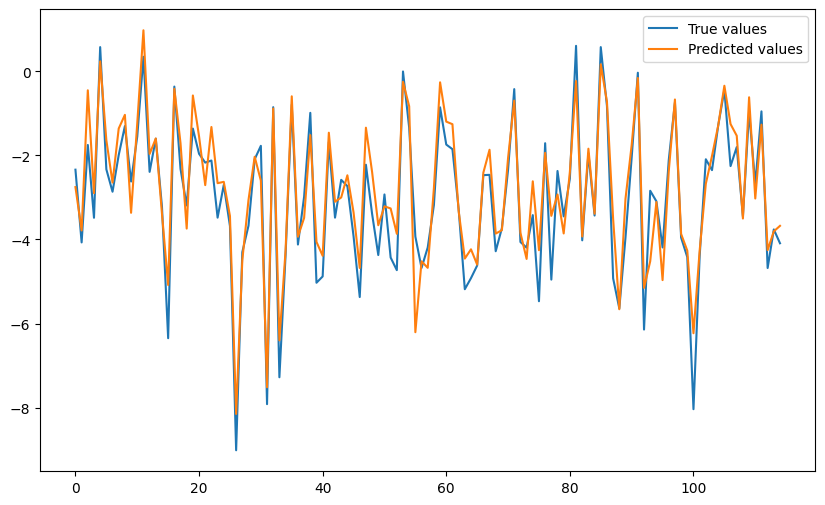

In [53]:
# Visualization of Predicted values and real values.
import matplotlib.pyplot as plt

y = torch.Tensor([])
for x in test_loader:
  y = torch.cat([y, x.y.squeeze()], dim = 0)

y = y.numpy()
y_hat = predict(hi_gnn, test_loader)


plt.figure(figsize=(10,6))

# Plotting y
plt.plot(y, label='True values')

# Plotting yhat
plt.plot(y_hat, label='Predicted values')

plt.legend()
plt.show()

# Section - 4: Arrakis GNN

In [15]:
def linear_layer(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels),
                      nn.BatchNorm1d(out_channels),
                      nn.LeakyReLU(1e-02))

def attn_heads(in_channels, out_channels):
  return nn.Sequential(nn.Linear(in_channels, out_channels), nn.Tanh())

class ResLayer(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()
    self.l1 = linear_layer(in_c, out_c)
    self.l2 = linear_layer(out_c, out_c)
    self.l3 = linear_layer(out_c, out_c)

  def forward(self, x):
    x = self.l1(x)
    return self.l3(self.l2(x)) + x

class GATv2ConvEV2(MessagePassing):

  def __init__(self, n_in, n_out, e_in, e_out):
    super().__init__(aggr = 'add')
    self.n_transform = ResLayer(n_in, n_out)
    self.e_transform = ResLayer(e_in, e_out)

    # Node
    self.n_attn = attn_heads(2*n_out + e_out, 1)
    self.e_attn = attn_heads(2*n_out + e_out, 1)
    self.s_attn = attn_heads(2*n_out + e_out, 1)
    self.n_message = ResLayer(e_out + 2*n_out , n_out)

    # For Edge
    self.n1_attn = ResLayer(e_out + 2*n_out, 1)
    self.n2_attn = ResLayer(e_out + 2*n_out, 1)
    self.s_e_attn = ResLayer(e_out + 2*n_out, 1)

    # For Node Update
    self.u_m_attn = attn_heads(2*n_out, 1)
    self.u_s_attn = attn_heads(2*n_out, 1)
    self.n_update = ResLayer(2*n_out, n_out)

    self.e_update = ResLayer(e_out + 2*n_out, e_out)

    self.n_in = n_in
    self.n_out = n_out
    self.e_in = e_in
    self.e_out = e_out

  def forward(self, x, edge_index, edge_attr):
    # st()
    x = self.n_transform(x)
    edge_attr = self.e_transform(edge_attr)

    node_features = self.propagate(edge_index, x = x, edge_attr = edge_attr)
    edge_features = self.edge_updater(edge_index, x = x, edge_attr = edge_attr)

    return node_features, edge_features

  def edge_update(self, edge_index, x_i, x_j, edge_attr):
    # 2. Edge Message Calculation

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    n1_attn = self.n1_attn(input)
    n2_attn = self.n2_attn(input)
    self_attn = self.s_e_attn(input)

    edge_message = torch.cat([n1_attn*x_i, n2_attn*x_j, self_attn*edge_attr], dim = 1)
    return self.e_update(edge_message) + edge_attr

  def message(self, x_i, x_j, edge_index, edge_attr):

    input = torch.cat([x_i, x_j, edge_attr], dim = 1)
    # 1. Node Message Calculation

    neighbour_attn = self.n_attn(input)
    edge_attn = self.e_attn(input)
    self_attn = self.s_attn(input)

    # 1.1 Attention Softmax
    neighbour_attn = softmax(neighbour_attn, edge_index[0])
    edge_attn = softmax(edge_attn, edge_index[0])
    self_attn = softmax(self_attn, edge_index[0])

    # 1.2 Gather the message
    node_message = torch.cat([self_attn*x_i, neighbour_attn*x_j, edge_attn*edge_attr], dim = 1)

    op = self.n_message(node_message)
    return op

  def update(self, aggregated_output, x):
    '''
    input = aggregated_output || x
    message_attn = msg_attn(input)
    self_attn = self_attn(input)

    h` = update(message_attn*aggregated_output || self_attn*x)
    return h`
    '''

    input = torch.cat([aggregated_output, x], dim = 1)
    m_attn = self.u_m_attn(input)
    s_attn = self.u_s_attn(input)

    return self.n_update(torch.cat([m_attn*aggregated_output, s_attn*x], dim = 1))


class GATV2(torch.nn.Module):
    def __init__(self, hidden_channels = 64, num_node_features = 45, num_edge_features = 10, num_classes = 1, regression = True):
        super(GATV2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATv2ConvEV2(num_node_features, hidden_channels, num_edge_features, hidden_channels)
        self.conv2 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv3 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)
        self.conv4 = GATv2ConvEV2(hidden_channels, hidden_channels, hidden_channels, hidden_channels)



        self.regression = regression
        if regression:
          self.lin = nn.Sequential(nn.Linear(hidden_channels, 1))
        else:
          self.lin = ResLayer(hidden_channels, num_classes)

    def forward(self, data):
        # 1. Obtain node embeddings
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x, edge_attr = self.conv1(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv2(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv3(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.4), F.dropout(edge_attr, p = 0.4)
        x, edge_attr = self.conv4(x, edge_index, edge_attr = edge_attr)
        x, edge_attr = F.dropout(x, p = 0.2), F.dropout(edge_attr, p = 0.2)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.2, training=self.training)
        if self.regression:
          x = self.lin(x)
        else:
          x = F.sigmoid(self.lin(x))


        return x



In [15]:
wandb.init('ArrakisGNN')

Train Loss Running Mean,█▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE Running Mean,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss Running Mean,█▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation RMSE Running Mean,█▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▂▂▁▂▁▁▁▂▁▁▁▁
Train Loss Running Mean,0.42819
Train RMSE Running Mean,0.64755
Validation Loss Running Mean,0.40583
Validation RMSE Running Mean,0.63276


In [ ]:
model = GATV2()
train_regression(model, train_loader, val_loader, learning_rate = 1e-03, epochs = 250, wd = 1e-03)

In [24]:
model = GATV2()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-03, weight_decay = 1e-03)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode = 'min',
            factor = 0.7,
            patience = 10,
            min_lr = 5e-05
)

criterion = torch.nn.MSELoss()
device = torch.device('cuda')
model.to(device)

def train():
    model.train()
    train_losses = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data)
        # out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.squeeze(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for data in val_loader:
            data.to(device)
            out = model(data)
            loss = criterion(out.squeeze(), data.y)
            val_losses.append(loss.item())
        lr_scheduler.step(np.mean(val_losses))

    print(f'Train RMSE: {np.mean(np.sqrt(train_losses))}, Valid Losses: {np.mean(np.sqrt(val_losses))}')


for epoch in range(1, 300):
    train()

Train RMSE: 2.9842989082883293, Valid Losses: 2.0001142014262925
Train RMSE: 2.0052198688360208, Valid Losses: 1.5607009951337156
Train RMSE: 1.8054535464676715, Valid Losses: 1.5882145020316658
Train RMSE: 1.6523577884707499, Valid Losses: 1.374557775719843
Train RMSE: 1.491449343441479, Valid Losses: 1.2262336184969234
Train RMSE: 1.4258951208972241, Valid Losses: 1.2955457708651807
Train RMSE: 1.3840052125224263, Valid Losses: 1.1915894334570798
Train RMSE: 1.294500570910789, Valid Losses: 1.117678510115483
Train RMSE: 1.3465072802813542, Valid Losses: 1.063530416003561
Train RMSE: 1.2431030223101454, Valid Losses: 1.05867431905123
Train RMSE: 1.1683893622934538, Valid Losses: 1.0310755200833497
Train RMSE: 1.230765673701987, Valid Losses: 1.0652530511989535
Train RMSE: 1.1934999292610886, Valid Losses: 0.9520675769795193
Train RMSE: 1.2311406807763772, Valid Losses: 1.1153399344622132
Train RMSE: 1.1862570692436782, Valid Losses: 1.0834075012270958
Train RMSE: 1.1589314785727323, V

In [55]:
layer = nn.TransformerEncoderLayer(128, 4, 512, dropout = 0.2)

In [59]:
x = torch.randn(32, 64, 128)

In [61]:
yhat = layer(x)

In [63]:
yhat.shape

torch.Size([32, 64, 128])

In [16]:
batch = next(iter(train_loader))

In [18]:
batch

MolDataBatch(x=[465, 45], edge_index=[2, 978], edge_attr=[978, 10], cluster_index=[465], fra_edge_index=[2, 900], fra_edge_attr=[900, 10], y=[32], batch=[465], ptr=[33])

In [19]:
layer = GATv2ConvEV2(batch.num_node_features, 128, batch.num_edge_features, 128)

In [23]:
node_attr, edge_attr = layer(batch.x, batch.edge_index, batch.edge_attr)

In [27]:
node_attr.shape

torch.Size([465, 128])